# Information Extraction from migraine.com

[Migraine.com](https://migraine.com/) is an excellent source on people sharing their experiences with migraine, the challenges they face, and how they deal with them.  The advantage of Migraine.com over migraine subreddit is that it is more organized and focussed on the topics within the available categories.  In addition user's post with their real names so this would allow us to identify gender of the user as an additional piece of information.

The forum of posts is:
https://migraine.com/forums

This site doesn't provide APIs so its forums need to be scraped.  Migraines.com `Terms of Use` specify that one needs to get permission for scraping their articles, however, the robots.txt file doesn't prohibit scraping of migraines.com/forums:

[robots.txt](https://migraine.com/robots.txt)
```
User-agent: *
Disallow: /dashboard/wp-admin/
Disallow: /members/
Disallow: /wp-login.php
Disallow: /community/members/
Disallow: /dashboard/wp-login.php
Disallow: /not-acceptable/
Disallow: /*preview_id=*
Disallow: /weekly/
Disallow: /create-thread
Disallow: /recipes/new
Disallow: /stories/new
Disallow: /unsubscribe
Disallow: /profile
Disallow: /messages
#FTF Disallows
Disallow: /activity/
Disallow: /search/
Disallow: /*?s=*
Disallow: /*acpage=*
Disallow: /*_wpnonce=*
Disallow: /*redirect=*
Disallow: /*sharedId=*
## XML Sitemap locations
Sitemap: https://migraine.com/sitemap_index.xml
```

These forums contain 326 pages of forum posts. Extraction was undertaken using selenium to open each page of posts and find the webpage of all forum topics. Selenium was further used to go to each topic and extract the parent comment, and each reply. 

One challenge was that not all replies are shown, but instead requires a reader to click an expand button to see more replies. Often a further button was nested, requiring more clicks. A while loop was used to search for these buttons, and selenium was used to click the buttons until they did not exist any more. A quirk in the page often required the page to be scrolled up to allow the click operation to work properly. An example of the item to click is below, "View 12 previous replies" 
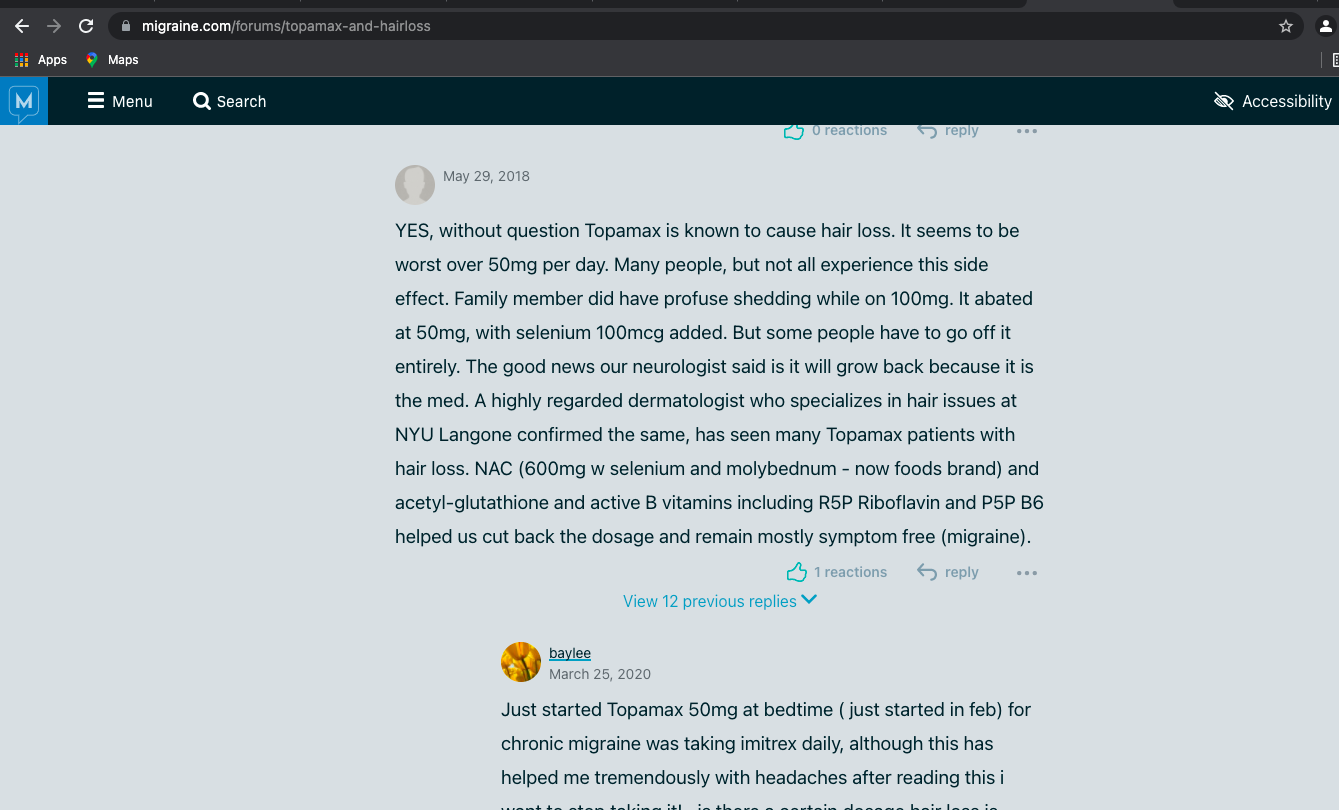

The script was able to pull the following information:
    
    Type: Parent ('P') or child ('C') comment
    
    Parent: If a parent comment, a sequential integer is used to identify
            Child comments use the parent identifier appended with a '.' and a second sequential integer, to allow user to find the parent comment
            
    Author: migraine.com user ID for the comment author
    
    Text: Text of comment
    
    Tags: User added tags to the parent post (We currently do not use this info on our downstream data parsing)
    
  
    

In [1]:
#Code requires the following python modules:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import csv
from os.path import exists

In [11]:
# Code also requires setup of a webdriver, in this case chromedriver is used. 
# User needs to ensure proper paths are set up
DRIVER_BIN = 'chromedriver'
pages = []
ID = 1
migraine_file_name = 'migraine.com.csv'
existingTitles = set()
existingTitles.add('/forums/life-with-the-constant-pulsating-pain')
existingTitles.add('/forums/neck-pain-1')
field_names = ['Type', 'Parent', 'Author', 'Text', 'Title','Tags','Webpage']

#Check to see if data exists, if so previous accessed webpages are ignored
#Note: This does not check to see if a parent topic had additional replies added since last run
if not exists(f'data/{migraine_file_name}'):
    posts_file = open(f'data/{migraine_file_name}', 'w')
    csv_writer = csv.DictWriter(posts_file, fieldnames=field_names)
    csv_writer.writeheader()
    posts_file.close()
else:
    posts_file = open(f'data/{migraine_file_name}', 'r')
    contents = csv.reader(posts_file)
    for lines in contents:
        existingTitles.add(lines[6])
    posts_file.close()

In [13]:
#Find pages of posts
#Set range to be pages of posts found on the main forum page. 
#This is set to 1 in this file, to reduce runtime, but as of 11/24/2021 should be set to 326 to get all posts
    
driver = webdriver.Chrome(executable_path = DRIVER_BIN)
root = 'https://migraine.com'
for i in range(1):
    driver.get('https://migraine.com/forums?page={}'.format(i+1))
    content = driver.page_source
    soup = BeautifulSoup(content,features="html.parser")
    for a in soup.findAll('a',href=True, attrs={'class':"thread-teaser__heading-link"}):
        if a['href'] not in existingTitles:
            pages.append(a['href'])
posts_file = open(f'data/{migraine_file_name}', 'a')
csv_writer = csv.DictWriter(posts_file, fieldnames=field_names)

In [14]:
#Go through each topic and find each parent and all child comments
pagecount = 0
for page in pages:
    pagecount+=1
    print(page)
    print('Page {} of {}'.format(pagecount,len(pages)))
    parent = {'Type':'P','Parent' : ID, 'Tags' : [],'Webpage' : page}
    webpage = root + page
    driver.get(webpage)
    content = driver.page_source
    soup = BeautifulSoup(content,features="html.parser")
    count = 0
    while soup.findAll('button',attrs={'class':"thread-discussion__toggle"}) or soup.findAll('button',attrs={'class':"thread-child-replies__toggle"}):
      
        if soup.findAll('button',attrs={'class':"thread-discussion__toggle"}):
            element = driver.find_element_by_class_name("thread-discussion__toggle")
            try:
                element.click()
                count = 0
            except:
                print(1,count)
                count += 1
                html = driver.find_element_by_tag_name('html')
                html.send_keys(Keys.PAGE_UP) 
                if count == 50:
                    count=0
                    break
                continue
        else:
            element = driver.find_element_by_class_name("thread-child-replies__toggle")
           # sp(1)
            try:
                element.click()
                print('success')
                count = 0
            except:
                print(2,count)
                html = driver.find_element_by_tag_name('html')
                html.send_keys(Keys.PAGE_UP) 
                count += 1
                if count == 50:
                    count = 0
                    break
                continue
        content = driver.page_source
        soup = BeautifulSoup(content,features="html.parser")
    for a in soup.findAll('h1',attrs={'class':"forum-thread__heading"}):
        if a != None:
            parent['Title'] = a.text
    for a in soup.findAll('div',attrs={'class':"forum-thread__body"}):
        if a != None:
            parent['Text'] = a.text
    for a in soup.findAll(href=True,attrs={'class':"tags-list__tag-link"}): 
        parent['Tags'].append(a.text)
    for a in soup.findAll('div',attrs={'class':'forum-thread__content'}):
        name = a.find('span',attrs={'class':"byline__name byline__name--with-tooltip"})
        if name != None:
            parent['Author'] = name.text
    
    csv_writer.writerow(parent)   
    for a in soup.findAll('ol',attrs={'class':'thread-discussion__list'}):
        childID = 1
        
        for b in a.findAll('div',attrs={'class':'thread-reply'}):
            IDparent = str(ID) + '.' + str(childID)
            child = {'Type':'C','Parent' : IDparent, 'Tags' : [], 'Title' : parent['Title']}
            name = b.find('span',attrs={'class':"byline__name byline__name--with-tooltip"})
            if name != None:    
                child['Author'] = name.text
            body = b.find('div',attrs={'class' : 'thread-reply__body'})
            if body != None:
                child['Text'] = body.text
            csv_writer.writerow(child) 
            
            
            childID += 1
    posts_file.close()
    posts_file = open(f'data/{migraine_file_name}', 'a')
    csv_writer = csv.DictWriter(posts_file, fieldnames=field_names)
    ID += 1

#input('Press ENTER to close the automated browser')
driver.quit()
posts_file.close()

/forums/migraines-more-frequent-since-covid-vaccine-and-since-getting-eyes-tested
Page 1 of 2


<ipython-input-14-9d3dc3d71249>:16: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  element = driver.find_element_by_class_name("thread-discussion__toggle")
<ipython-input-14-9d3dc3d71249>:30: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  element = driver.find_element_by_class_name("thread-child-replies__toggle")


2 0


<ipython-input-14-9d3dc3d71249>:38: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_tag_name('html')


2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
success
success
/forums/brief-aura
Page 2 of 2
